<a href="https://colab.research.google.com/github/BreckoD/DataSciencePracticum2023/blob/main/Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install torch
!pip install -qq transformers tokenizers sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import string
import re
import numpy as np
import torch

from datasets import load_dataset
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransforme
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from scipy.spatial.distance import cosine

from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Data Vizualization

In [ ]:
df_train = pd.DataFrame({"text": dataset["train"]["text"], "label": dataset["train"]["label"]})
df_test = pd.DataFrame({"text": dataset["test"]["text"], "label": dataset["test"]["label"]})
df_train

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [ ]:
for review in df_train["text"].iloc[:10]:
  print(review, '\n')

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

<Axes: title={'center': 'Test label distribution'}>

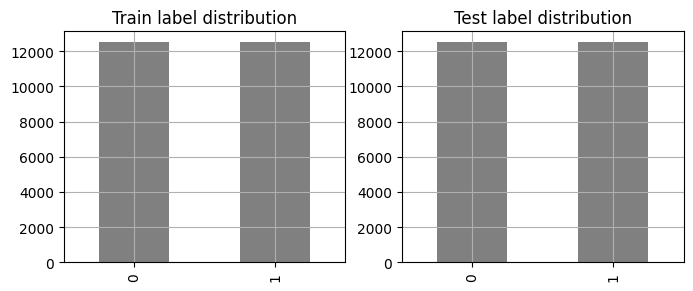

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
df_train["label"].value_counts().plot(kind='bar', grid=True, color="gray", ax=ax1, title="Train label distribution")
df_test["label"].value_counts().plot(kind='bar', grid=True, color="gray", ax=ax2, title="Test label distribution")

## Data Cleaning

In [ ]:
def clean_text(review):

  review = review.lower() # lowercase
  review = re.sub(r'https?://\S+|www\.\S+', '', review) # remove links
  review = review.replace("<br /><br />", " ") # remove line break elements
  review = review.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
  review = re.sub(r'\d+', '', review) # remove digits
  review = re.sub(r' +', ' ', review) # remove extra whitespace

  printable = set(string.printable)
  review = ''.join(filter(lambda x: x in printable, review)) # remove nonascii characters

  return review

In [ ]:
for review in df_train["text"].iloc[:10]:
  review = clean_text(review)
  print(review, '\n')

i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in i also heard that at first it was seized by us customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myself the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married men what kills me about i am curiousyellow is that years ago this was considered pornographic really the sex and nudity scenes are few and far between even then its not shot like some cheaply made porno 

In [ ]:
df_train["text_cleaned"] = df_train["text"].apply(lambda x: clean_text(x))
df_test["text_cleaned"] = df_test["text"].apply(lambda x: clean_text(x))

In [ ]:
df_train.duplicated().sum()

96

## Embeddings and cosine distance

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
minilm_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

In [ ]:
print("Distance between review of one category: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text"].iloc[1]),
    minilm_model.encode(df_train["text"].iloc[2])))
)
print("Distance between review of different categories: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text"].iloc[-1]),
    minilm_model.encode(df_train["text"].iloc[1]))), '\n'
    )

print("Distance between review (cleaned) of one category: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[2])))
)
print("Distance between review (cleaned) of different categories: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[-1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[1])))
)

Distance between review of one category: 0.726
Distance between review of different categories: 0.928 

Distance between review (cleaned) of one category: 0.680
Distance between review (cleaned) of different categories: 0.869


In [ ]:
# just curious how text cleaning affects cosine distance

def cosine_diff(idx_i, idx_j, ax, title, num_sample=500):

  idx_i_loc = df_train.iloc[np.random.choice(idx_i, num_sample)].copy()
  idx_j_loc = df_train.iloc[np.random.choice(idx_j, num_sample)].copy()

  idx_i_loc["text_emb"] = idx_i_loc["text"].progress_apply(lambda x:  minilm_model.encode(x))
  idx_j_loc["text_emb"] = idx_j_loc["text"].progress_apply(lambda x:  minilm_model.encode(x))

  idx_i_loc["text_cleaned_emb"] = idx_i_loc["text_cleaned"].progress_apply(lambda x:  minilm_model.encode(x))
  idx_j_loc["text_cleaned_emb"] = idx_j_loc["text_cleaned"].progress_apply(lambda x:  minilm_model.encode(x))

  emb_cosine = np.array(list(map(
    lambda x: cosine(x[0], x[1]),
    zip(idx_i_loc["text_emb"].to_list(),  idx_j_loc["text_emb"].to_list())
    )))

  emb_cleaned_cosine = np.array(list(map(
    lambda x: cosine(x[0], x[1]),
    zip(idx_i_loc["text_cleaned_emb"].to_list(),  idx_j_loc["text_cleaned_emb"].to_list())
    )))

  diff = emb_cleaned_cosine - emb_cosine
  ax.hist(diff, bins=50, color="gray")
  ax.set_title(title)
  ax.set_xlabel("cosine_cleaned - cosine")
  ax.text(.80, .90, diff.mean().round(3), transform=ax.transAxes)
  ax.grid()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

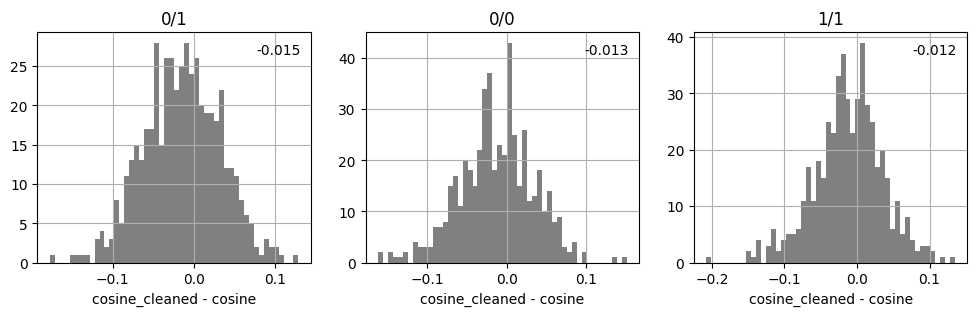

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))
neg_ids = df_train[df_train["label"] == 0].index
pos_ids = df_train[df_train["label"] == 1].index

cosine_diff(neg_ids, pos_ids, num_sample=500, title="0/1", ax=ax1)
cosine_diff(neg_ids, neg_ids, num_sample=500, title="0/0", ax=ax2)
cosine_diff(pos_ids, pos_ids, num_sample=500, title="1/1", ax=ax3)

## The most similar negative reviews

In [ ]:
pos_loc = df_train.iloc[np.random.choice(neg_ids, 500, replace=False)].copy()
pos_loc["text_cleaned_emb"] = pos_loc["text_cleaned"].progress_apply(lambda x: minilm_model.encode(x))

cosine_matrix = pos_loc["text_cleaned_emb"].progress_apply(
    lambda i: pos_loc["text_cleaned_emb"].apply(lambda j: cosine(i, j))
    )

np.fill_diagonal(cosine_matrix.to_numpy(), np.inf)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
i_idx = cosine_matrix.min().sort_values().idxmin()
j_idx = cosine_matrix[i_idx].sort_values().index[0]

print("Min cosine value: {:.3f}".format(cosine_matrix.loc[i_idx, j_idx]), "\n")
print(f"Review {i_idx}:", pos_loc.loc[[i_idx, j_idx]]["text"].iloc[0])
print(f"Review {j_idx}:", pos_loc.loc[[i_idx, j_idx]]["text"].iloc[1])

Min cosine value: 0.238 

Review 10280: This show is a perfect example of how the CBC should stick to either news, sports, or satirical sketch comedy. As a developer of situation comedy, CBC has shown it can combine the pizazz of "King of Kensington" with the belly laughs of "The Beachcombers". It is an embarrassment to great shows like "Kids in the Hall" and "Second City" that they have to share their comedic roots with this lame production.<br /><br />I have to admit, that I didn't give this show much of a chance right from when I first heard of its concept. To start, half of the concept is a direct attempt to rip-off one of the few sitcom successes in English-Canadian history, "Corner Gas". The rest of the concept--the cultural clash--is far from being original and is too often used as a crutch for screen writing laziness. The selection of the Muslim religion as the basis for the "fish out of water" characters seems to be a desperate attempt to be "edgy" and "topical", but comes off

## Fine-tune Distilbert model for classification on the IMDB data

In [ ]:
MODEL = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Set the pad_token to a special token (e.g., eos_token)
#tokenizer.pad_token = tokenizer.eos_token


def preprocess_function(examples):
    return tokenizer(examples["text"], return_tensors="pt", truncation=True,
    padding=True)

train_dataset = dataset['train'].select(range(500)).map(preprocess_function, batched=True)
valid_dataset = dataset['train'].select(range(500,1000)).map(preprocess_function, batched=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2  # if you change the dataset, do not forget to update
)

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np


def compute_metrics(p):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

#### Get embeddings from the fine-tuned model for test sample

In [ ]:
def get_embeddings(input_text, tokenizer, model):

  # Tokenize and encode the input
  input_ids = tokenizer(input_text, return_tensors="pt", truncation=True,
      padding=True)['input_ids']
  # Move the input tensor to the same device as the model
  input_ids = input_ids.to(model.device)

  # Forward pass
  with torch.no_grad():
      outputs = model(input_ids, output_hidden_states=True)

  # extract sentence embeddings of inputs
  hidden_states = outputs['hidden_states']

  sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
  return sentence_embedding

In [ ]:
test_dataset = dataset['test']
label_1_texts = [example['text'] for example in test_dataset if example['label'] == 1]
label_0_texts = [example['text'] for example in test_dataset if example['label'] == 0]

# get embeddings for first 100 samples - for each label
test_embed_1 = get_embeddings(label_1_texts[:100], tokenizer, model)
test_embed_0 = get_embeddings(label_0_texts[:100], tokenizer, model)

#### check cosine similarities among texts of positive/negtive reviews

In [ ]:
cosine_diff = np.array(list(map(
    lambda x: cosine(x[0], x[1]),
    zip(test_embed_0.cpu().numpy(), test_embed_1.cpu().numpy())
    )))

# Binary classification with sentence transformer


## Upload model via HF

In [38]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
train_model = AutoModelForSequenceClassification.from_pretrained('sentence-transformers/all-MiniLM-L6-v2',
                                                                 num_labels = 2)    # Download model and configuration from S3 and cache.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                    )

In [34]:
train_token_id = []
train_attention_masks = []

for sample in df_train['text_cleaned']:
  encoding_dict = preprocessing(sample, tokenizer)
  train_token_id.append(encoding_dict['input_ids'])
  train_attention_masks.append(encoding_dict['attention_mask'])


train_token_id = torch.cat(train_token_id, dim = 0)
train_attention_masks = torch.cat(train_attention_masks, dim = 0)
train_labels = torch.tensor(df_train['label'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [30]:
test_token_id = []
test_attention_masks = []

for sample in df_test['text_cleaned']:
  encoding_dict = preprocessing(sample, tokenizer)
  test_token_id.append(encoding_dict['input_ids'])
  test_attention_masks.append(encoding_dict['attention_mask'])


test_token_id = torch.cat(test_token_id, dim = 0)
test_attention_masks = torch.cat(test_attention_masks, dim = 0)
test_labels = torch.tensor(df_test['label'])

In [35]:
batch_size = 16

# Train and validation sets
train_set = TensorDataset(train_token_id,
                          train_attention_masks,
                          train_labels)

val_set = TensorDataset(test_token_id,
                        test_attention_masks,
                        test_labels)

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [39]:
optimizer = torch.optim.AdamW(train_model.parameters(),
                              lr = 5e-5,
                              eps = 1e-08
                              )

#Run on GPU
train_model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, e

## Metrics

In [41]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'

  return b_accuracy, b_precision, b_recall, b_specificity

## Training

In [43]:
from tqdm import trange
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):

  # ========== Training ==========

    # Set model to training mode
    train_model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = train_model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask,
                              labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    train_model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = train_model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  50%|█████     | 1/2 [02:13<02:13, 133.43s/it]


	 - Train loss: 0.3634
	 - Validation Accuracy: 0.8552
	 - Validation Precision: 0.5141
	 - Validation Recall: 0.9015
	 - Validation Specificity: 0.8089



Epoch: 100%|██████████| 2/2 [04:22<00:00, 131.18s/it]


	 - Train loss: 0.2362
	 - Validation Accuracy: 0.8762
	 - Validation Precision: 0.5206
	 - Validation Recall: 0.9168
	 - Validation Specificity: 0.8354



In [71]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[1][-1] #Last hidden layer of model_output contains all token embeddings

    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [77]:
# Sentences we want sentence embeddings for
sentences = [df_train["text_cleaned"].iloc[1], df_train["text_cleaned"].iloc[2], df_train["text_cleaned"].iloc[-1]]

#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = train_model(**encoded_input.to(device),output_hidden_states=True)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1).cpu()

In [79]:
print("Distance between review (pre-trained model) of one category: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[2])))
)
print("Distance between review (pre-trained model) of different categories: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[-1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[1]))), '\n'
    )

print("Distance between review (new model) of one category: {:.3f}".format(cosine(
    sentence_embeddings[0],
    sentence_embeddings[1]))
)
print("Distance between review (new model) of different categories: {:.3f}".format(cosine(
    sentence_embeddings[2],
    sentence_embeddings[0]))
)

Distance between review (pre-trained model) of one category: 0.680
Distance between review (pre-trained model) of different categories: 0.869 

Distance between review (new model) of one category: 0.129
Distance between review (new model) of different categories: 1.796


## The distance increased for different categories and decreased for same category, which is **good**

In [82]:
train_model.save_pretrained("all-Mini-finetuned-imdb", from_pt=True)

In [92]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /roo

In [93]:
tokenizer.push_to_hub('DBretsko/all-Mini-finetuned-imdb')
train_model.push_to_hub('DBretsko/all-Mini-finetuned-imdb')

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DBretsko/all-Mini-finetuned-imdb/commit/e5e56ee5db074800a671ec7c34ade1ceabedebe0', commit_message='Upload BertForSequenceClassification', commit_description='', oid='e5e56ee5db074800a671ec7c34ade1ceabedebe0', pr_url=None, pr_revision=None, pr_num=None)